# Лабораторная работа №3.2: Тематическое моделирование
## 1. Импорт необходимых библиотек


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from scipy import stats
import warnings
warnings.filterwarnings('ignore')
import json
import pickle
import os
from tqdm import tqdm


## 2. Загрузка данных и подготовка term-document матрицы


In [ ]:
train_df = pd.read_csv('train.csv', header=None, names=['label', 'title', 'text'])
test_df = pd.read_csv('test.csv', header=None, names=['label', 'title', 'text'])

print(f"Размер обучающей выборки: {train_df.shape}")
print(f"Размер тестовой выборки: {test_df.shape}")


Размер обучающей выборки: (120000, 3)
Размер тестовой выборки: (7600, 3)


In [ ]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')

def preprocess_text(text):
    text = text.lower()
    # Удаление специальных символов и цифр
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
    return ' '.join(tokens)

train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)

print("Пример обработанного текста:")
print(train_df['processed_text'].iloc[0][:200])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Пример обработанного текста:
reuters shortsellers wall streets dwindlingband ultracynics seeing green


## 3. Создание term-document матрицы


In [ ]:
# Создание матрицы "термин-документ" с использованием CountVectorizer
def create_term_document_matrix(texts, max_features=5000):
    vectorizer = CountVectorizer(
        max_features=max_features,
        stop_words='english',
        max_df=0.95,
        min_df=2
    )
    td_matrix = vectorizer.fit_transform(texts)
    feature_names = vectorizer.get_feature_names_out()
    
    return td_matrix, feature_names, vectorizer

# Создаем матрицу для обучающих данных
td_matrix_train, feature_names, vectorizer = create_term_document_matrix(
    train_df['processed_text'].tolist(),
    max_features=3000
)

# Создаем матрицу для тестовых данных
td_matrix_test = vectorizer.transform(test_df['processed_text'].tolist())

print(f"Размер term-document матрицы (обучение): {td_matrix_train.shape}")
print(f"Размер term-document матрицы (тест): {td_matrix_test.shape}")


Размер term-document матрицы (обучение): (120000, 3000)
Размер term-document матрицы (тест): (7600, 3000)


## 4. Эксперименты с LDA с разным количеством тем


In [ ]:
def train_lda_models(td_matrix, n_topics_list, max_iter=10, random_state=42):
    models = {}
    
    for n_topics in tqdm(n_topics_list, desc="Обучение LDA моделей"):
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=max_iter,
            learning_method='online',
            random_state=random_state,
            n_jobs=-1
        )
        
        # Обучение модели
        lda.fit(td_matrix)
        models[n_topics] = lda
    
    return models

n_topics_list = [2, 5, 10, 20, 40]
# Добавляем количество тем, равное количеству классов (4 для AG News)
n_topics_list_with_classes = n_topics_list + [4]

lda_models = train_lda_models(td_matrix_train, n_topics_list_with_classes)


Обучение LDA моделей: 100%|██████████| 6/6 [20:52<00:00, 208.74s/it]


## 5. Анализ моделей: топ-ключевые слова


In [ ]:
def get_top_keywords(model, feature_names, n_top_words=10):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        top_features_ind = topic.argsort()[:-n_top_words - 1:-1]
        top_features = [feature_names[i] for i in top_features_ind]
        topics.append(top_features)
    
    return topics

def print_topics_info(models, feature_names, n_top_words=10):
    results = {}
    
    for n_topics, model in models.items():
        print(f"\n{'='*60}")
        print(f"Модель LDA с {n_topics} темами:")
        print(f"{'='*60}")
        
        topics = get_top_keywords(model, feature_names, n_top_words)
        results[n_topics] = topics
        
        for topic_idx, topic_words in enumerate(topics):
            print(f"\nТема #{topic_idx + 1}:")
            print(f"  {', '.join(topic_words)}")
    
    return results

topics_results = print_topics_info(lda_models, feature_names)



Модель LDA с 2 темами:

Тема #1:
  new, said, reuters, company, million, corp, oil, year, york, percent

Тема #2:
  said, new, president, reuters, sunday, game, world, yesterday, saturday, night

Модель LDA с 5 темами:

Тема #1:
  sunday, new, night, game, world, win, saturday, victory, league, killed

Тема #2:
  season, state, yesterday, coach, lead, bank, wednesday, left, friday, court

Тема #3:
  said, reuters, new, million, company, oil, percent, york, year, thursday

Тема #4:
  new, software, microsoft, internet, according, service, computer, online, home, deal

Тема #5:
  said, president, government, people, quot, reuters, iraq, minister, united, officials

Модель LDA с 10 темами:

Тема #1:
  monday, tuesday, president, said, reuters, united, bush, report, agreed, john

Тема #2:
  game, night, win, team, season, coach, sports, final, second, games

Тема #3:
  reuters, new, said, oil, york, prices, year, friday, company, wednesday

Тема #4:
  minister, iraq, said, prime, killed, 

## 6. Расчет perplexity для тестовой выборки


In [ ]:
def calculate_perplexities(models, td_matrix_test):
    perplexities = {}
    
    for n_topics, model in tqdm(models.items(), desc="Расчет perplexity"):
        perplexity = model.perplexity(td_matrix_test)
        perplexities[n_topics] = perplexity
    
    return perplexities

perplexities = calculate_perplexities(lda_models, td_matrix_test)

print("\nPerplexity для разных моделей:")
print("-" * 40)
for n_topics, perplexity in sorted(perplexities.items()):
    print(f"Количество тем: {n_topics:2d} | Perplexity: {perplexity:.2f}")


Расчет perplexity: 100%|██████████| 6/6 [00:05<00:00,  1.10it/s]


Perplexity для разных моделей:
----------------------------------------
Количество тем:  2 | Perplexity: 1770.88
Количество тем:  4 | Perplexity: 1943.63
Количество тем:  5 | Perplexity: 2126.13
Количество тем: 10 | Perplexity: 2817.56
Количество тем: 20 | Perplexity: 3673.71
Количество тем: 40 | Perplexity: 6048.33


## 7. Вероятности принадлежности документов к темам


In [ ]:
def get_document_topic_probabilities(model, td_matrix):
    return model.transform(td_matrix)

def save_topic_probabilities(models, td_matrix, doc_ids, output_dir='topic_probabilities'):
    os.makedirs(output_dir, exist_ok=True)
    
    for n_topics, model in models.items():
        # Получаем вероятности
        topic_probs = get_document_topic_probabilities(model, td_matrix)
        
        # Сохраняем в TSV формате
        filename = os.path.join(output_dir, f'topic_probs_{n_topics}_topics.tsv')
        with open(filename, 'w') as f:
            for doc_id, probs in zip(doc_ids, topic_probs):
                # Форматируем вероятности
                probs_str = '\t'.join([f"{p:.6f}" for p in probs])
                f.write(f"{doc_id}\t{probs_str}\n")
        
        # Сохраняем документы с наибольшей вероятностью для каждой темы
        save_top_documents_per_topic(model, td_matrix, train_df, n_topics, output_dir)
    
    print(f"\nРезультаты сохранены в директории: {output_dir}")

def save_top_documents_per_topic(model, td_matrix, df, n_topics, output_dir, n_docs=5):
    topic_probs = get_document_topic_probabilities(model, td_matrix)
    
    results = {}
    for topic_idx in range(n_topics):
        # Получаем индексы документов с наибольшей вероятностью для данной темы
        top_doc_indices = topic_probs[:, topic_idx].argsort()[-n_docs:][::-1]
        
        topic_docs = []
        for idx in top_doc_indices:
            doc_info = {
                'doc_id': int(idx),
                'probability': float(topic_probs[idx, topic_idx]),
                'text_preview': str(df['text'].iloc[idx])[:200] + "...",
                'title': str(df['title'].iloc[idx]),
                'label': int(df['label'].iloc[idx])
            }
            topic_docs.append(doc_info)
        
        results[f'topic_{topic_idx + 1}'] = topic_docs
    
    filename = os.path.join(output_dir, f'top_docs_{n_topics}_topics.json')
    with open(filename, 'w') as f:
        json.dump(results, f, indent=2, ensure_ascii=False)

doc_ids = [f"train_{i:05d}" for i in range(len(train_df))]

save_topic_probabilities(lda_models, td_matrix_train, doc_ids)



Результаты сохранены в директории: topic_probabilities


## 8. Визуализация perplexity и полиномиальная аппроксимация


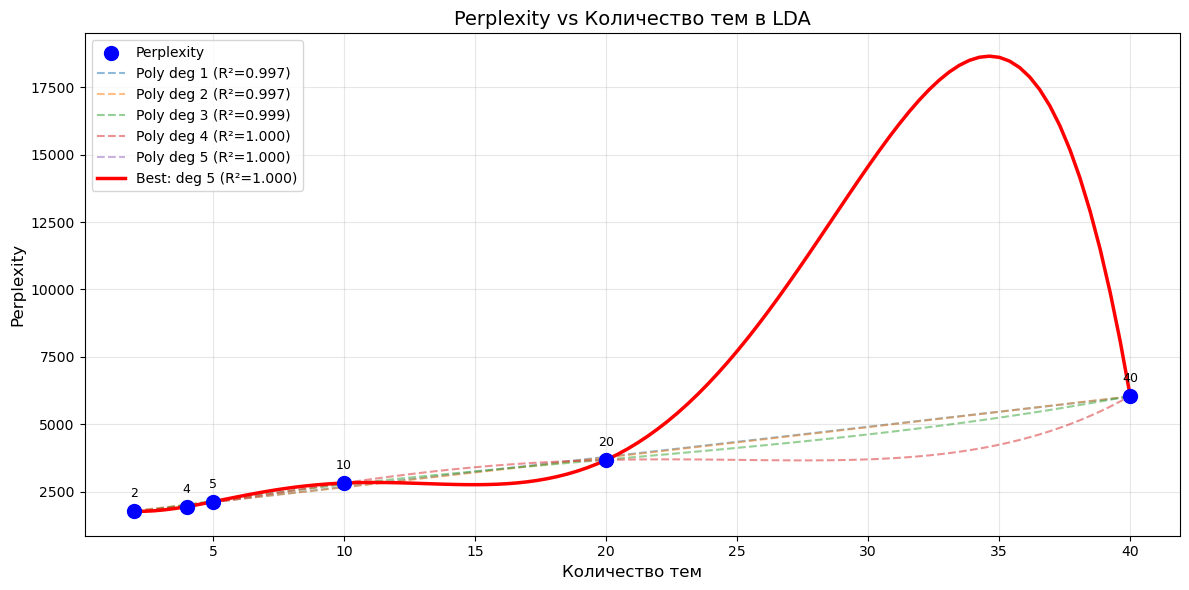


Лучшая полиномиальная аппроксимация: степень 5
Коэффициент детерминации R²: 1.0000
Коэффициенты полинома: [-7.63526696e-03  6.00149928e-01 -1.52927231e+01  1.54536119e+02
 -4.80878479e+02  2.22748113e+03]


In [ ]:
def plot_perplexity_with_polyfit(perplexities, max_degree=5):
    n_topics_list = sorted(perplexities.keys())
    perplexity_values = [perplexities[n] for n in n_topics_list]
    
    x = np.array(n_topics_list)
    y = np.array(perplexity_values)
    
    plt.figure(figsize=(12, 6))
    
    plt.scatter(x, y, s=100, color='blue', label='Perplexity', zorder=5)
    
    best_degree = 1
    best_r2 = -np.inf
    
    x_smooth = np.linspace(min(x), max(x), 100)
    
    for degree in range(1, max_degree + 1):
        try:
            # Аппроксимация полиномом
            coeffs = np.polyfit(x, y, degree)
            poly = np.poly1d(coeffs)
            y_pred = poly(x)
            
            # Вычисляем R²
            residuals = y - y_pred
            ss_res = np.sum(residuals**2)
            ss_tot = np.sum((y - np.mean(y))**2)
            r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
            
            # Если это лучший R², обновляем
            if r2 > best_r2:
                best_r2 = r2
                best_degree = degree
                best_poly = poly
            
            # Рисуем аппроксимацию
            y_smooth = poly(x_smooth)
            plt.plot(x_smooth, y_smooth, '--', alpha=0.5, 
                    label=f'Poly deg {degree} (R²={r2:.3f})')
            
        except:
            continue
    
    y_best = best_poly(x_smooth)
    plt.plot(x_smooth, y_best, 'r-', linewidth=2.5, 
            label=f'Best: deg {best_degree} (R²={best_r2:.3f})')
    
    plt.xlabel('Количество тем', fontsize=12)
    plt.ylabel('Perplexity', fontsize=12)
    plt.title('Perplexity vs Количество тем в LDA', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend(loc='best')
    
    for i, txt in enumerate(n_topics_list):
        plt.annotate(f'{txt}', (x[i], y[i]), 
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9)
    
    plt.tight_layout()
    plt.savefig('perplexity_vs_topics.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return best_degree, best_r2, best_poly

best_degree, best_r2, best_poly = plot_perplexity_with_polyfit(perplexities)

print(f"\nЛучшая полиномиальная аппроксимация: степень {best_degree}")
print(f"Коэффициент детерминации R²: {best_r2:.4f}")
print(f"Коэффициенты полинома: {best_poly.coeffs}")


## 9. Определение оптимального количества тем


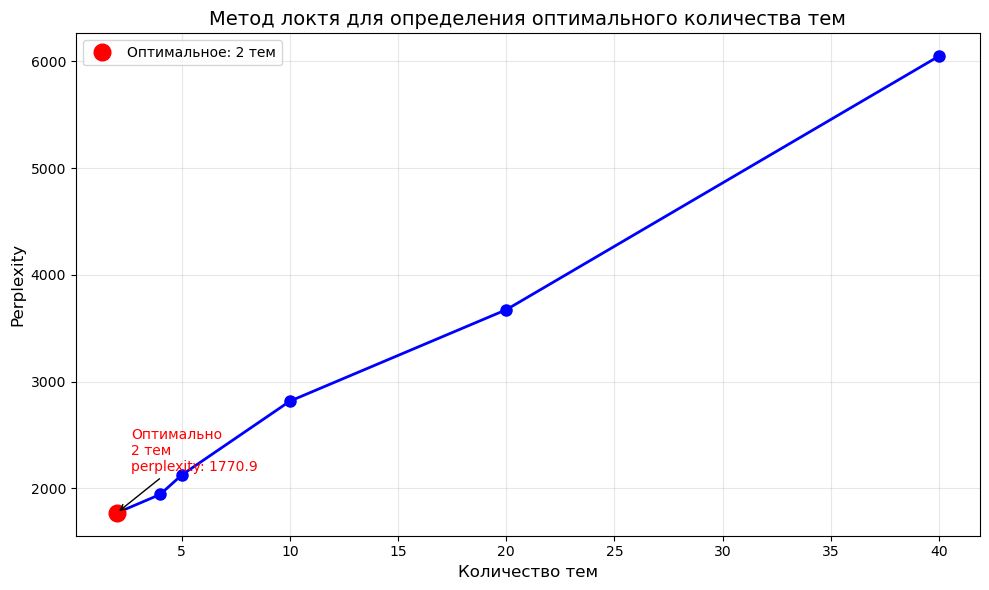


АНАЛИЗ ОПТИМАЛЬНОГО КОЛИЧЕСТВА ТЕМ

На основе анализа perplexity оптимальное количество тем: 2
Perplexity для 2 тем: 1770.88

Топ-10 ключевых слов для оптимальной модели (2 тем):

Тема #1:
  new, said, reuters, company, million, corp, oil, year, york, percent

Тема #2:
  said, new, president, reuters, sunday, game, world, yesterday, saturday, night


In [ ]:
def find_optimal_topics(perplexities, best_poly, best_degree):
    # Сортируем perplexity по возрастанию (меньше - лучше для LDA)
    sorted_perplexities = sorted(perplexities.items(), key=lambda x: x[1])
    
    n_topics_list = sorted(perplexities.keys())
    perplexity_values = [perplexities[n] for n in n_topics_list]
    
    # Вычисляем первую производную (скорость изменения perplexity)
    if len(n_topics_list) > 1:
        # Используем полином для вычисления производной
        derivative = np.polyder(best_poly)
        
        # Вычисляем производную в точках
        derivative_values = derivative(np.array(n_topics_list))
        
        # Находим точку, где производная начинает меняться медленнее
        if len(derivative_values) > 1:
            # Нормализуем производные
            deriv_norm = np.abs(derivative_values) / np.max(np.abs(derivative_values))
            
            # Ищем точку, где производная становится меньше порога
            threshold = 0.3
            optimal_idx = None
            for i in range(len(deriv_norm) - 1):
                if deriv_norm[i] < threshold and derivative_values[i] < 0:
                    optimal_idx = i
                    break
            
            if optimal_idx is not None:
                optimal_n_topics = n_topics_list[optimal_idx]
            else:
                # Если не нашли по порогу, берем первое значение с наименьшей perplexity
                optimal_n_topics = sorted_perplexities[0][0]
        else:
            optimal_n_topics = sorted_perplexities[0][0]
    else:
        optimal_n_topics = sorted_perplexities[0][0]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(n_topics_list, perplexity_values, 'bo-', linewidth=2, markersize=8)
    plt.plot(optimal_n_topics, perplexities[optimal_n_topics], 'ro', 
             markersize=12, label=f'Оптимальное: {optimal_n_topics} тем')
    
    plt.xlabel('Количество тем', fontsize=12)
    plt.ylabel('Perplexity', fontsize=12)
    plt.title('Метод локтя для определения оптимального количества тем', fontsize=14)
    plt.grid(True, alpha=0.3)
    plt.legend()
    
    for i, (n, p) in enumerate(zip(n_topics_list, perplexity_values)):
        if n == optimal_n_topics:
            plt.annotate(f'Оптимально\n{n} тем\nperplexity: {p:.1f}',
                        xy=(n, p), xytext=(10, 30),
                        textcoords='offset points',
                        arrowprops=dict(arrowstyle='->'),
                        fontsize=10, color='red')
    
    plt.tight_layout()
    plt.savefig('optimal_topics_elbow.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    return optimal_n_topics

optimal_n_topics = find_optimal_topics(perplexities, best_poly, best_degree)

print(f"\n{'='*60}")
print("АНАЛИЗ ОПТИМАЛЬНОГО КОЛИЧЕСТВА ТЕМ")
print(f"{'='*60}")
print(f"\nНа основе анализа perplexity оптимальное количество тем: {optimal_n_topics}")
print(f"Perplexity для {optimal_n_topics} тем: {perplexities[optimal_n_topics]:.2f}")

print(f"\nТоп-10 ключевых слов для оптимальной модели ({optimal_n_topics} тем):")
optimal_topics = topics_results[optimal_n_topics]
for i, topic_words in enumerate(optimal_topics):
    print(f"\nТема #{i+1}:")
    print(f"  {', '.join(topic_words)}")


## 10. Эксперименты с разным количеством итераций


In [ ]:
def experiment_with_iterations(td_matrix_train, td_matrix_test, n_topics, 
                              base_iterations=10, random_state=42):
    iterations_list = [base_iterations // 2, base_iterations, base_iterations * 2]
    results = {}
    
    for n_iter in tqdm(iterations_list, desc="Эксперименты с итерациями"):
        lda = LatentDirichletAllocation(
            n_components=n_topics,
            max_iter=n_iter,
            learning_method='online',
            random_state=random_state,
            n_jobs=-1
        )
        
        lda.fit(td_matrix_train)
        
        train_perplexity = lda.perplexity(td_matrix_train)
        test_perplexity = lda.perplexity(td_matrix_test)
        
        topics = get_top_keywords(lda, feature_names, n_top_words=10)
        
        results[n_iter] = {
            'model': lda,
            'train_perplexity': train_perplexity,
            'test_perplexity': test_perplexity,
            'topics': topics,
            'convergence_iter': lda.n_iter_
        }
    
    return results

print(f"\nПроводим эксперименты с количеством итераций для {optimal_n_topics} тем...")
iteration_results = experiment_with_iterations(
    td_matrix_train, td_matrix_test, 
    n_topics=optimal_n_topics,
    base_iterations=10
)

print("\nРезультаты экспериментов с количеством итераций:")
print("-" * 60)
for n_iter, res in iteration_results.items():
    print(f"\nКоличество итераций: {n_iter}")
    print(f"  Фактическое количество итераций до сходимости: {res['convergence_iter']}")
    print(f"  Perplexity на обучении: {res['train_perplexity']:.2f}")
    print(f"  Perplexity на тесте: {res['test_perplexity']:.2f}")
    print(f"  Разница (тест - обучение): {res['test_perplexity'] - res['train_perplexity']:.2f}")



Проводим эксперименты с количеством итераций для 2 тем...


Эксперименты с итерациями: 100%|██████████| 3/3 [08:14<00:00, 164.94s/it]


Результаты экспериментов с количеством итераций:
------------------------------------------------------------

Количество итераций: 5
  Фактическое количество итераций до сходимости: 5
  Perplexity на обучении: 1512.29
  Perplexity на тесте: 1785.04
  Разница (тест - обучение): 272.75

Количество итераций: 10
  Фактическое количество итераций до сходимости: 10
  Perplexity на обучении: 1500.95
  Perplexity на тесте: 1770.88
  Разница (тест - обучение): 269.94

Количество итераций: 20
  Фактическое количество итераций до сходимости: 20
  Perplexity на обучении: 1497.12
  Perplexity на тесте: 1766.33
  Разница (тест - обучение): 269.21


## 11. Визуализация результатов экспериментов с итерациями


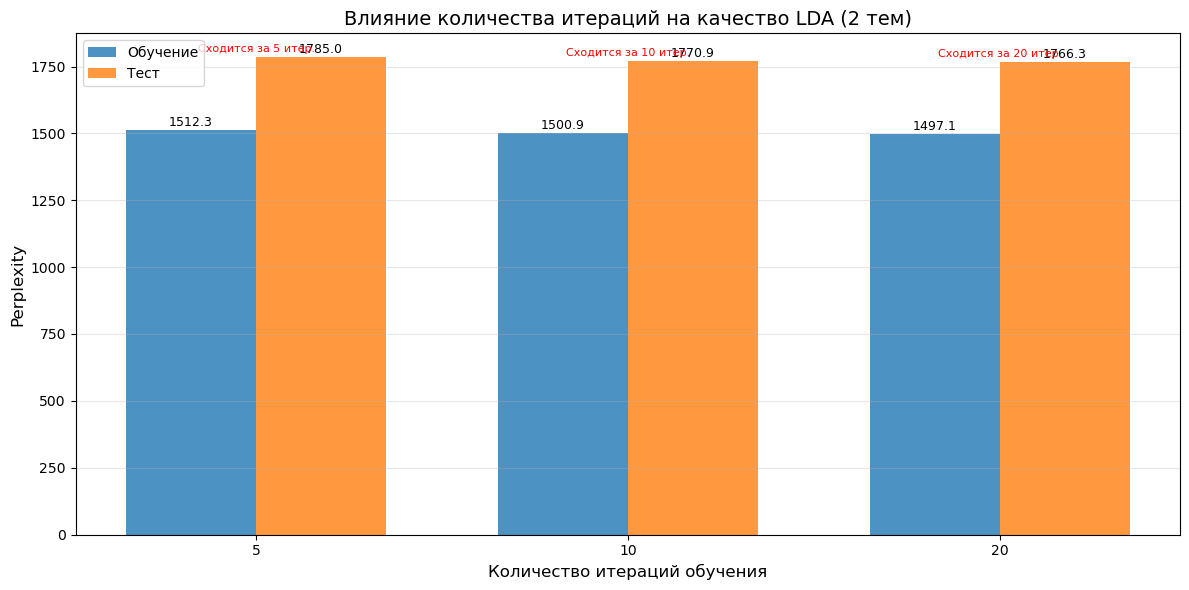


Анализ переобучения:
----------------------------------------
Итерации 5: разница тест-обучение = 272.75
Итерации 10: разница тест-обучение = 269.94
Итерации 20: разница тест-обучение = 269.21


In [ ]:
def plot_iteration_experiments(iteration_results):
    iterations = list(iteration_results.keys())
    train_perplexities = [res['train_perplexity'] for res in iteration_results.values()]
    test_perplexities = [res['test_perplexity'] for res in iteration_results.values()]
    
    plt.figure(figsize=(12, 6))
    
    width = 0.35
    x = np.arange(len(iterations))
    
    plt.bar(x - width/2, train_perplexities, width, label='Обучение', alpha=0.8)
    plt.bar(x + width/2, test_perplexities, width, label='Тест', alpha=0.8)
    
    for i, (train, test) in enumerate(zip(train_perplexities, test_perplexities)):
        plt.text(i - width/2, train + 5, f'{train:.1f}', 
                ha='center', va='bottom', fontsize=9)
        plt.text(i + width/2, test + 5, f'{test:.1f}', 
                ha='center', va='bottom', fontsize=9)
    
    plt.xlabel('Количество итераций обучения', fontsize=12)
    plt.ylabel('Perplexity', fontsize=12)
    plt.title(f'Влияние количества итераций на качество LDA ({optimal_n_topics} тем)', fontsize=14)
    plt.xticks(x, [str(i) for i in iterations])
    plt.legend()
    plt.grid(True, alpha=0.3, axis='y')
    
    for i, (n_iter, res) in enumerate(iteration_results.items()):
        plt.text(i, max(train_perplexities[i], test_perplexities[i]) + 20,
                f'Сходится за {res["convergence_iter"]} итер.',
                ha='center', fontsize=8, color='red')
    
    plt.tight_layout()
    plt.savefig('iteration_experiments.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\nАнализ переобучения:")
    print("-" * 40)
    for n_iter, res in iteration_results.items():
        overfit_gap = res['test_perplexity'] - res['train_perplexity']
        print(f"Итерации {n_iter}: разница тест-обучение = {overfit_gap:.2f}")

plot_iteration_experiments(iteration_results)
